# Predicting Scalar Coupling constant

The goal of this competition is to predict the scalar coupling constant between atoms in a given molecule.

You are given: 
- Atom types(elements)
- Coupling type
- 3d structure, given in XYZ coordinates

Files provided:
- train, gives the atom information
- test, testing data
- structures, the 3d structures

Extra files(will NOT be given during the actual scoring)
- dipole moments
- magnetic shielding tensors
- mulliken charges
- potential energy
- scalar coupling contributions

First, just import libraries

In [2]:
# standard libraries for data wrangling & visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# machine learning libraries
import tensorflow as tf
from keras.layers import Dense, Input, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model

# other libraries
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


#### Importing
Import all the data as data frames and then (optionally) reduce the memory usage for better performance

This can take a while depending on the performance of your machine

In [3]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
df_struct = pd.read_csv('input/structures.csv')

df_potential = pd.read_csv('input/potential_energy.csv')
df_dipole = pd.read_csv('input/dipole_moments.csv')
df_mulliken = pd.read_csv('input/mulliken_charges.csv')
df_magnetic = pd.read_csv('input/magnetic_shielding_tensors.csv')

df_scc = pd.read_csv('input/scalar_coupling_contributions.csv')

In [4]:
# reduce_mem_usage taken from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_struct = reduce_mem_usage(df_struct)

df_potential = reduce_mem_usage(df_potential)
df_dipole = reduce_mem_usage(df_dipole)
df_mulliken = reduce_mem_usage(df_mulliken)
df_magnetic = reduce_mem_usage(df_magnetic)

df_scc = reduce_mem_usage(df_scc)

Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)


Be wary that the memory reduction does reduce the accuracy of the data so be sure to keep looking at the original

Now lets look at some of the data

In [40]:
df_train[['type', 'scalar_coupling_constant']].head(20)

,type,scalar_coupling_constant
0,1JHC,84.812500
1,2JHH,-11.257812
2,2JHH,-11.257812
3,2JHH,-11.257812
4,1JHC,84.812500
5,2JHH,-11.257812
6,2JHH,-11.257812
7,1JHC,84.812500
8,2JHH,-11.257812
9,1JHC,84.812500


At first glance, it seems that the type plays a big role in determining the scalar coupling constant. Looking at other public kernels, it seems like creating a model for each type is the best performance

Let's try looking at the distribution for each of the types

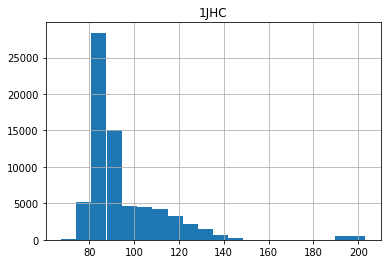

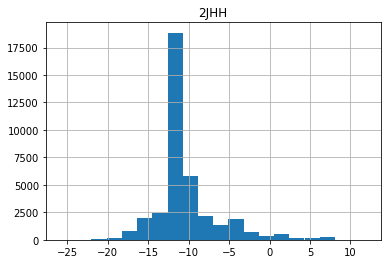

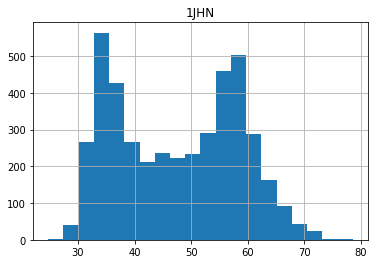

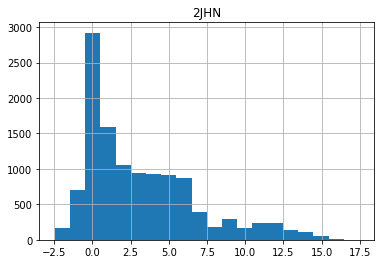

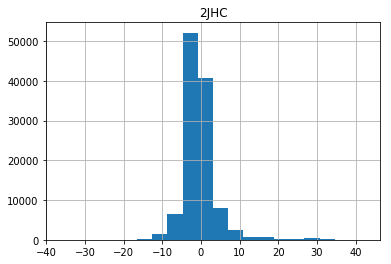

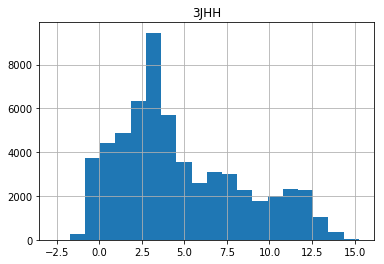

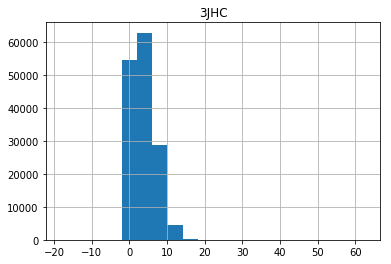

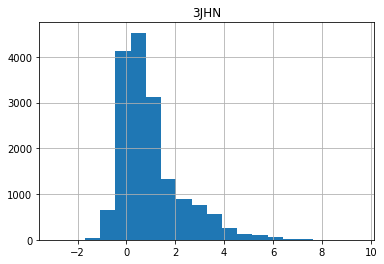

In [41]:
types = df_train['type'].unique()
for i in range(df_train['type'].nunique()):
    t = types[i]
    plt.title(t)
    plt.show(df_train['scalar_coupling_constant'][(df_train.type == t)][::10].hist(bins=20))
    

Each type has quite a different distribution, so custom models would be the best, afterall the test data DOES provide the coupling type